![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )


Smallest sphere enclosing a set of points.
===========================


The aim of this tutorial is two-fold

1. Demostrate how to write a conic quadratic model in `Fusion` in a very simple and compact way.
2. Show how and way the dual formulation may solved more efficiently.


Our problem is the defined as:

**Find the smallest sphere that encloses a set of** $k$ **points** $p_i \in \mathbb{R}^n$. 


The problem boils down to determine the sphere center $c_0\in \mathbb{R}^n$ and its radius $r_0\geq 0$, i.e.


\begin{equation}
  \begin{aligned}
\min \max_{i=1,\dots,k} \| p_i - p_0\|_2 \\
  \end{aligned}
\end{equation}

The maximum in the objective function can be easily, i.e.

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_i \geq \| p_i - p_0\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& (r_0,p_i - p_0) \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

The `fusion` implementatin starts defining the optimization model:

Before defining the constraints, we note that we can write


\begin{equation}
r = \left(r_0,\ldots,r_0\right)^T \in \mathbb{R}^k
\end{equation}

and 

\begin{equation}
P = \left(p_0,\ldots,p_k\right)^T \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
(r_0,p_i - p_0) \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
(r,P) \in \Pi Q^{(n+1)}.
\end{equation}

Now we are ready for a compact implementation in `Fusion`:

In [86]:
from mosek.fusion import *

def primal_problem(n,k,p):
    M = Model("minimal sphere enclosing a set of points")

    r0 = M.variable(1         , Domain.greaterThan(0.))
    p0 = M.variable(NDSet(1,n), Domain.unbounded())

    M.constraint(\
        Expr.hstack(\
                    Variable.repeat(r0,k),\
                    Expr.sub( Variable.repeat(p0,k), DenseMatrix(p) )\
                   ),\
            Domain.inQCone())

    M.objective(ObjectiveSense.Minimize, r0)
    M.setLogHandler(open('logp','wt'))

    M.solve()

    return r0.level()[0], p0.level()

For sake of simplicity we will consider

* $n=2$,
* no restriction on the sphere center location.

Our input data will be generate randomly around the origin with a standard normal distibution.

Here it is:

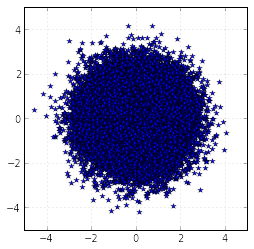

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

def plot_points(p, p0=[], r0=0.):
    n,k= len(p0), len(p)
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([ p[i][0] for i in range(k)], [ p[i][1] for i in range(k)], 'b*')
    
    if len(p0)>0:
        ax.plot(  p0[0], p0[1], 'r.')
        ax.add_patch( mpatches.Circle( p0,  r0 ,  fc="w", ec="r", lw=1.5) )
    plt.grid()
    plt.show()

n = 2
k = 50000

p=  [ [random.gauss(0.,1.) for nn in range(n)] for kk in range(k)]

plot_points(p)

We will also store the solver output in a file to use it later on. And then just solve the problem.

In [88]:
r0,p0 = primal_problem(n,k,p)

print "r0^* = ", r0
print "p0^* = ", p0

r0^* =  4.44316767149
p0^* =  [-0.11071004986558852, 0.07928615691553509]


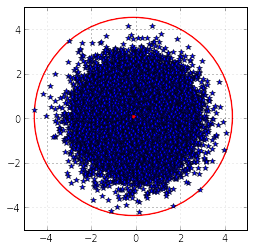

In [89]:
plot_points(p,p0,r0)

Dual Formulation 
-----------------------


Let's derive the dual:

\begin{aligned}
    \max & \sum_i b_i^T y_i \\
    & \sum_i y_i = c \\
    & y_i \in \mathcal{Q}^{n+1}
\end{aligned}


where $c=\left(1, 0_n\right)^T$ and $b_i=(0,p_i)$. Introducing 

\begin{equation}
 Y = \left[ y_0, \ldots,y_k  \right], B=\left[ b_1,\ldots,b_k\right]
\end{equation}


\begin{aligned}
    \max & \left< B, Y \right> \\
    & Y \mathbb{1}_k = c \\
    & Y_{:,i} \in \mathcal{Q}^{n+1}
\end{aligned}



In [90]:
def dual_problem(n,k,p):
    
    Md = Model()

    y= Md.variable(NDSet(k,n+1), Domain.inQCone(k,n+1))
    Md.constraint( Expr.mul( [1.0 for i in range(k)], y), Domain.equalsTo( [1.] + [0. for i in range(n)]) )
    
    Md.objective(ObjectiveSense.Maximize, Expr.dot( DenseMatrix(p), y.slice([0,1],[k,n+1])) )
 
    Md.setLogHandler(open('logd','wt'))

    Md.solve()

    
dual_problem(n,k,p)

Let's take a closer look to the solver output:

In [99]:
!tail  log*

==> logd <==
15  6.6e-04  1.5e-08  1.3e-08  1.00e+00   4.443289589e+00   4.443213899e+00   1.3e-08  1.87  
16  2.7e-04  6.2e-09  5.5e-09  1.00e+00   4.443195982e+00   4.443167649e+00   5.5e-09  1.97  
17  7.0e-05  1.6e-09  1.4e-09  1.00e+00   4.443171625e+00   4.443166015e+00   1.4e-09  2.08  
18  5.8e-06  1.3e-10  2.3e-10  1.00e+00   4.443164926e+00   4.443164501e+00   1.2e-10  2.19  
19  3.3e-07  7.4e-12  3.5e-10  1.00e+00   4.443164418e+00   4.443164393e+00   6.5e-12  2.31  
20  3.1e-08  3.8e-13  1.0e-08  1.00e+00   4.443164343e+00   4.443164387e+00   3.4e-13  2.42  
21  3.1e-08  3.8e-13  1.0e-08  1.00e+00   4.443164343e+00   4.443164387e+00   3.4e-13  2.70  
Interior-point optimizer terminated. Time: 2.70. 

Optimizer terminated. Time: 2.74    

==> logp <==
11  1.9e-05  1.5e-05  3.0e-05  1.36e+00   4.617911240e+00   4.732417551e+00   1.5e-05  3.94  
12  5.8e-06  4.6e-06  9.2e-06  1.08e+00   4.492831481e+00   4.524966531e+00   4.6e-06  4.20  
13  2.1e-06  1.7e-06  3.4e-06  1.02e+00

In [100]:
!grep Scalar log*

logd:  Scalar variables       : 150000          
logd:Optimizer  - Scalar variables       : 150000            conic                  : 150000          
logp:  Scalar variables       : 150003          
logp:Optimizer  - Scalar variables       : 150000            conic                  : 150000          


In [101]:
!grep Cones log*

logd:  Cones                  : 50000           
logd:Optimizer  - Cones                  : 50000
logp:  Cones                  : 50000           
logp:Optimizer  - Cones                  : 50000


In [102]:
!grep Constraints log*


logd:  Constraints            : 3               
logd:Optimizer  - Constraints            : 3
logp:  Constraints            : 150000          
logp:Optimizer  - Constraints            : 149997


Why is that? `Fusion` perform the following transformation:

\begin{equation}
Ax - b \in \mathcal{K} \rightarrow \quad \left\lbrace\begin{array}{ll} y = Ax-b\\ y\in \mathcal{K} \end{array}\right.
\end{equation}

The reason is to ensure each variable to belong only in cone (in the `optimizer API` this must be done by the user).

But this is not the reason: 

* **MOSEK** uses a primal-dual algorithm that will solve both formulation at the same time,
* therefore internally there is no difference;


**So why is the dual formulation so much faster?**

The answer comes from a closer inspection to the solver output, in particular the reported `flops`:


In [103]:
!grep flop log* 

logd:Factor     - dense dim.             : 0                 flops                  : 1.30e+06        
logp:Factor     - dense dim.             : 5                 flops                  : 9.70e+06        


In [104]:
!grep flop log* | cut -d':' -f 4 | xargs printf "1/(%f/%f)\n" | bc -l

7.46153846153846153889


In [97]:
!grep "Interior-point optimizer" log* | cut -d':' -f 3| cut -d'.' -f1-2  | xargs printf "1/(%f/%f)\n" | bc -l

2.18888888888888888890


When moving from theory to practical implementation, **MOSEK** is somehow biased towards the primal, i.e. the formulation we input:

* some steps, most notably fatorizations, are order dependent,
* it is important to not be mislead by the problem dimension looking only at the number of variables, constraints and cones
* if performance are a concern, both primal and dual should be tried.

Hopefully we will include an automatic dualizer tool in the future release. But it will be still a heuristic.




<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" property="cc:attributionName" rel="cc:attributionURL">MOSEK ApS</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="www.mosek.com" rel="dct:source">www.mosek.com</a>.

In [98]:
!cat logd


Computer
  Platform               : Linux/64-X86    
  Cores                  : 2               

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3               
  Cones                  : 50000           
  Scalar variables       : 150000          
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.04    
Optimizer  - threads           